In [ ]:
from glob import glob
import numpy as np
from astropy.table import QTable, vstack
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.interpolate import interp1d

plt.style.use('paper')

In [ ]:
def custom_sort(arr):
    def key_func(item):
        # Extract number from string and convert to integer
        num = int(item[4:])  # 'conf' has length 4
        # Return a tuple with two items:
        # First item is a boolean indicating if number is 10 (True for 'conf10' and False otherwise)
        # Second item is the number itself
        # This will sort 'conf10' last and others based on their numbers
        return (num == 10, num)
    
    return sorted(arr, key=key_func)

In [ ]:
which = 'gaussians'
version = '_gaussians_v4'
# version = '_v2'

# which_time = ''
# which_time = '_6totaltime'
# which_time = '_6totaltime_flagged'
# which_time = '_60totaltime'
# which_time = '_60totaltime_flagged'

which_time = '_6totaltime_noise'
# which_time = '_6totaltime_flagged_noise'
# which_time = '_60totaltime_noise'
# which_time = '_60totaltime_flagged_noise'

if 'noise' in which_time:
    # model scaling factor
    model_f = 15000
    if '60' in which_time:
        model_f = model_f*np.sqrt(10)
else: 
    model_f  = 1

table = vstack([QTable.read(file) for file in glob(f'../data/tables{version}/table_fit_{which}{which_time}_conf*.fits')])
conf_unique = np.unique(table['conf']) 
conf_unique =  custom_sort(conf_unique)
conf_unique_ = np.unique(table['conf_']) 

min_baseline =  [8.7, 14.6, 14.6, 14.6, 14.6, 14.6, 14.6, 64.0, 110.4, 367.6, 244.0,]
mrs_size =      [66.7, 28.5, 22.6, 16.2, 11.2, 6.7, 4.11, 2.58, 1.42, 0.814, 0.496]
beam_size =     [12.5, 3.38, 2.3, 1.42, 0.918, 0.545, 0.306, 0.211, 0.096, 0.057, 0.042]
configuration = ['conf0', 'conf1', 'conf2', 'conf3', 'conf4', 'conf5', 'conf6', 'conf7', 'conf8', 'conf9', 'conf10']
mrs_conf = np.arange(0,11)

print(conf_unique)

table.sort('conf')
table[table['conf']=='conf8']

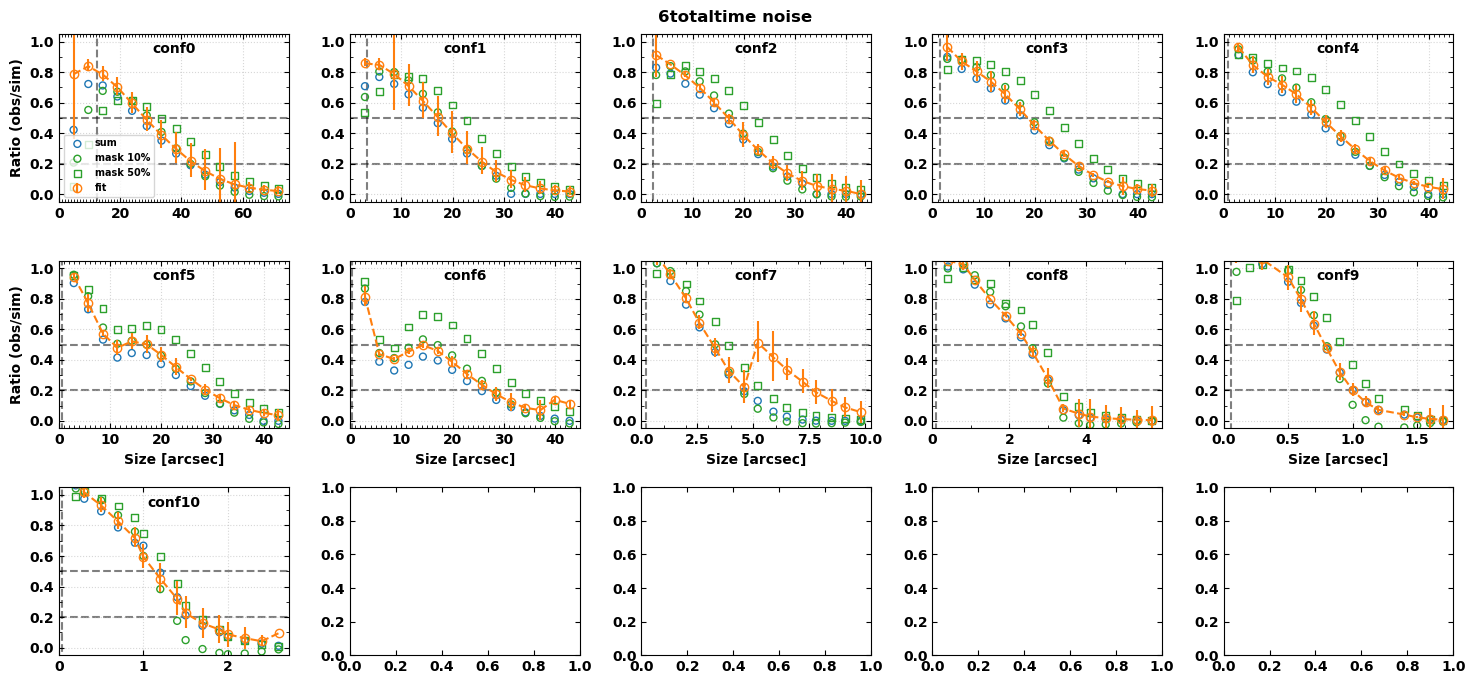

In [61]:
# Make scatter plot
fig1, ax1 = plt.subplots(3, 5, figsize=(15, 7))
ax1 = ax1.flatten()

colors = cm.turbo(np.linspace(0, 1, len(ax1)))

for i, conf in enumerate(conf_unique):

	if model_f!=1:  
		if conf == 'conf0':
			model_f_ = model_f/15
		else: 
			model_f_ = model_f
	else: 
		model_f_ = 1
		
	conf_tab = table[np.where(table['conf']==conf)]
	conf_arr = conf_tab['conf']
	wide_arr = [''] * len(conf_arr)

	sum_sim = conf_tab['sum_sim'].value/model_f_
	sum_obs = conf_tab['sum_obs'].value
	sum_fit_sim = conf_tab['sum_fit_sim'].value/model_f_
	sum_fit_obs = conf_tab['sum_fit_obs'].value
	errl_fit_sim = conf_tab['errl_fit_sim'].value/model_f_ 
	errh_fit_sim = conf_tab['errh_fit_sim'].value/model_f_
	errl_fit_obs = conf_tab['errl_fit_obs'].value 
	errh_fit_obs = conf_tab['errh_fit_obs'].value 
	sum_mask10_obs = conf_tab['sum_mask10_obs'].value
	sum_mask10_sim = conf_tab['sum_mask10_sim'].value/model_f_
	sum_mask50_obs = conf_tab['sum_mask50_obs'].value
	sum_mask50_sim = conf_tab['sum_mask50_sim'].value/model_f_
	ratio_arr = sum_obs/sum_sim
	ratio_fit_arr = sum_fit_obs/sum_fit_sim
	ratio_mask10_arr = sum_mask10_obs/sum_mask10_sim
	ratio_mask50_arr = sum_mask50_obs/sum_mask50_sim
	ratio_fiterrl_arr = errl_fit_obs/errl_fit_sim
	ratio_fiterrh_arr = errh_fit_obs/errh_fit_sim
	ferrh = np.abs(np.abs(errh_fit_obs-sum_fit_obs)/sum_fit_obs)
	ferrl = np.abs(np.abs(errl_fit_obs-sum_fit_obs)/sum_fit_obs)
	# ferrl[ferrl>10] = 100
	# ferrh[ferrh>10] = 100
	ratio_fiterrl_arr = np.abs(ratio_fit_arr*ferrl)
	ratio_fiterrh_arr = np.abs(ratio_fit_arr*ferrh)
	
	for j, wide in enumerate(conf_tab['wide']):
		wide_arr[j] = float(wide.replace('mrs0',''))
	wide_arr = np.array(wide_arr)

	ids = np.argsort(wide_arr)
	wide_arr = wide_arr[ids]
	ratio_fit_arr = ratio_fit_arr[ids]
	ratio_arr = ratio_arr[ids]
	ratio_mask10_arr = ratio_mask10_arr[ids]
	ratio_mask50_arr = ratio_mask50_arr[ids]

	#rati_arr
	ax1[i].scatter(wide_arr, ratio_arr, s=25, ec='C0', fc='none', label='sum')
	ax1[i].scatter(wide_arr, ratio_mask10_arr, s=25, ec='C2', fc='none', marker = 'o', label='mask 10%')
	ax1[i].scatter(wide_arr, ratio_mask50_arr, s=25, ec='C2', fc='none', marker = 's', label='mask 50%')

	ax1[i].errorbar(wide_arr, ratio_fit_arr, yerr=(ratio_fiterrl_arr, ratio_fiterrh_arr), color='C1', label='fit', fmt='o', markerfacecolor='none')	
	ax1[i].plot(wide_arr, ratio_fit_arr, ls='--', c='C1')

	ax1[i].text(0.5, 0.95, conf, transform=ax1[i].transAxes, weight='extra bold', fontsize=10, va='top', ha='center')
	ax1[i].set_ylim([-0.05, 1.05])
	
	xlim = ax1[i].get_xlim()
	ax1[i].hlines(0.2, 0, xlim[1], colors='k', ls='--', zorder=0, alpha=0.5)
	ax1[i].hlines(0.5, 0, xlim[1], colors='k', ls='--', zorder=0, alpha=0.5)
	ax1[i].vlines(beam_size[i], -2, 2,  colors='k', ls='--', zorder=0, alpha=0.5)

	ax1[i].set_xlim([0, xlim[1]])

	# ax1[i].xaxis.set_major_locator(MultipleLocator(10))
	ax1[i].xaxis.set_minor_locator(MultipleLocator(1))
	ax1[i].yaxis.set_minor_locator(MultipleLocator(0.1))
	ax1[i].grid(True, ls=':', alpha=0.5)

for i in [5,6,7,8,9]:
	ax1[i].set_xlabel('Size [arcsec]')

for i in [0,5]:
	ax1[i].set_ylabel('Ratio (obs/sim)')

ax1[0].legend(loc='lower left', fontsize=7)
	
fig1.suptitle(which_time.replace('_', ' ')[1:], fontweight='bold', y=0.97)

fig1.tight_layout()
# fig1.savefig(f'./../figs/scatter_ratio_{which}{which_time}.pdf', dpi=300, bbox_inches='tight', transparent=False)
fig1.savefig(f'./../figs/scatter_ratio_{which}{which_time}.png', dpi=300, bbox_inches='tight', transparent=False)

/var/folders/3y/cmsgt3_x7x72bbs__zhy_q6h0008wr/T/ipykernel_23682/582318355.py:42: RuntimeWarning: divide by zero encountered in divide
  ferrh = np.abs(np.abs(errh_fit_obs-sum_fit_obs)/sum_fit_obs)
/var/folders/3y/cmsgt3_x7x72bbs__zhy_q6h0008wr/T/ipykernel_23682/582318355.py:43: RuntimeWarning: divide by zero encountered in divide
  ferrl = np.abs(np.abs(errl_fit_obs-sum_fit_obs)/sum_fit_obs)
/var/folders/3y/cmsgt3_x7x72bbs__zhy_q6h0008wr/T/ipykernel_23682/582318355.py:46: RuntimeWarning: invalid value encountered in multiply
  ratio_fiterrl_arr = np.abs(ratio_fit_arr*ferrl)
/var/folders/3y/cmsgt3_x7x72bbs__zhy_q6h0008wr/T/ipykernel_23682/582318355.py:47: RuntimeWarning: invalid value encountered in multiply
  ratio_fiterrh_arr = np.abs(ratio_fit_arr*ferrh)


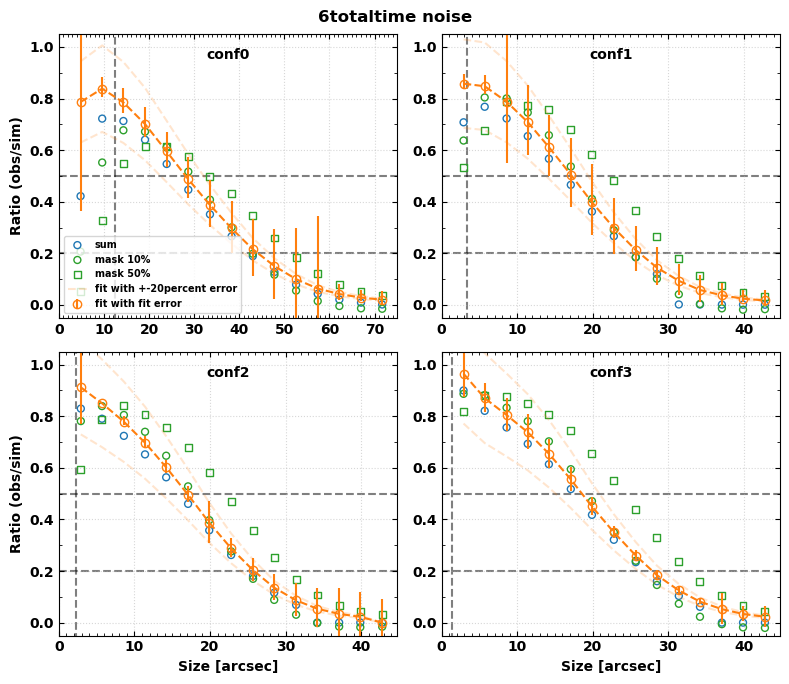

In [62]:
# Make scatter plot
fig1, ax1 = plt.subplots(2,2, figsize=(8, 7))
ax1 = ax1.flatten()

colors = cm.turbo(np.linspace(0, 1, len(ax1)))

for i, conf in enumerate(conf_unique):

	if i > 3:
		continue 

	if model_f!=1:  
		if conf == 'conf0':
			model_f_ = model_f/15
		else: 
			model_f_ = model_f
	else: 
		model_f_ = 1
		
	conf_tab = table[np.where(table['conf']==conf)]
	conf_arr = conf_tab['conf']
	wide_arr = [''] * len(conf_arr)

	sum_sim = conf_tab['sum_sim'].value/model_f_
	sum_obs = conf_tab['sum_obs'].value
	sum_fit_sim = conf_tab['sum_fit_sim'].value/model_f_
	sum_fit_obs = conf_tab['sum_fit_obs'].value
	errl_fit_sim = conf_tab['errl_fit_sim'].value/model_f_ 
	errh_fit_sim = conf_tab['errh_fit_sim'].value/model_f_
	errl_fit_obs = conf_tab['errl_fit_obs'].value 
	errh_fit_obs = conf_tab['errh_fit_obs'].value 
	sum_mask10_obs = conf_tab['sum_mask10_obs'].value
	sum_mask10_sim = conf_tab['sum_mask10_sim'].value/model_f_
	sum_mask50_obs = conf_tab['sum_mask50_obs'].value
	sum_mask50_sim = conf_tab['sum_mask50_sim'].value/model_f_
	ratio_arr = sum_obs/sum_sim
	ratio_fit_arr = sum_fit_obs/sum_fit_sim
	ratio_mask10_arr = sum_mask10_obs/sum_mask10_sim
	ratio_mask50_arr = sum_mask50_obs/sum_mask50_sim
	ratio_fiterrl_arr = errl_fit_obs/errl_fit_sim
	ratio_fiterrh_arr = errh_fit_obs/errh_fit_sim
	ferrh = np.abs(np.abs(errh_fit_obs-sum_fit_obs)/sum_fit_obs)
	ferrl = np.abs(np.abs(errl_fit_obs-sum_fit_obs)/sum_fit_obs)
	# ferrl[ferrl>10] = 100
	# ferrh[ferrh>10] = 100
	ratio_fiterrl_arr = np.abs(ratio_fit_arr*ferrl)
	ratio_fiterrh_arr = np.abs(ratio_fit_arr*ferrh)
	
	yerr = np.abs(np.array([ratio_fiterrl_arr, ratio_fiterrh_arr]))
	# threshold = ratio_fit_arr * 0.2
	# yerr[0][yerr[0] < threshold] = threshold[yerr[0] < threshold]
	# yerr[1][yerr[1] < threshold] = threshold[yerr[1] < threshold]

	for j, wide in enumerate(conf_tab['wide']):
		wide_arr[j] = float(wide.replace('mrs0',''))
	wide_arr = np.array(wide_arr)

	ids = np.argsort(wide_arr)
	wide_arr = wide_arr[ids]
	ratio_fit_arr = ratio_fit_arr[ids]
	ratio_arr = ratio_arr[ids]
	ratio_mask10_arr = ratio_mask10_arr[ids]
	ratio_mask50_arr = ratio_mask50_arr[ids]

	#rati_arr
	ax1[i].scatter(wide_arr, ratio_arr, s=25, ec='C0', fc='none', label='sum')
	ax1[i].scatter(wide_arr, ratio_mask10_arr, s=25, ec='C2', fc='none', marker = 'o', label='mask 10%')
	ax1[i].scatter(wide_arr, ratio_mask50_arr, s=25, ec='C2', fc='none', marker = 's', label='mask 50%')

	# ax1[i].errorbar(wide_arr, ratio_fit_arr, yerr=ratio_fit_arr*0.2, color='C1', label='fit with 20percent error', fmt='none', markerfacecolor='none', alpha=0.5, capsize=2)	

	ax1[i].plot(wide_arr, ratio_fit_arr-ratio_fit_arr*0.2, ls='--', color='C1', alpha=0.2, label='fit with +-20percent error')
	ax1[i].plot(wide_arr, ratio_fit_arr+ratio_fit_arr*0.2, ls='--', color='C1', alpha=0.2)

	ax1[i].errorbar(wide_arr, ratio_fit_arr, yerr=yerr, color='C1', label='fit with fit error', fmt='o', markerfacecolor='none')	
	ax1[i].plot(wide_arr, ratio_fit_arr, ls='--', c='C1')

	ax1[i].text(0.5, 0.95, conf, transform=ax1[i].transAxes, weight='extra bold', fontsize=10, va='top', ha='center')
	ax1[i].set_ylim([-0.05, 1.05])
	
	xlim = ax1[i].get_xlim()
	ax1[i].hlines(0.2, 0, xlim[1], colors='k', ls='--', zorder=0, alpha=0.5)
	ax1[i].hlines(0.5, 0, xlim[1], colors='k', ls='--', zorder=0, alpha=0.5)
	ax1[i].vlines(beam_size[i], -2, 2,  colors='k', ls='--', zorder=0, alpha=0.5)

	ax1[i].set_xlim([0, xlim[1]])

	# ax1[i].xaxis.set_major_locator(MultipleLocator(10))
	ax1[i].xaxis.set_minor_locator(MultipleLocator(1))
	ax1[i].yaxis.set_minor_locator(MultipleLocator(0.1))
	ax1[i].grid(True, ls=':', alpha=0.5)

for i in [2,3]:
	ax1[i].set_xlabel('Size [arcsec]')

for i in [0,2]:
	ax1[i].set_ylabel('Ratio (obs/sim)')

ax1[0].legend(loc='lower left', fontsize=7)
	
fig1.suptitle(which_time.replace('_', ' ')[1:], fontweight='bold', y=0.97)

fig1.tight_layout()
# fig1.savefig(f'./../figs/scatter_ratio_{which}{which_time}.pdf', dpi=300, bbox_inches='tight', transparent=False)
fig1.savefig(f'./../figs/scatter_ratio_{which}{which_time}_conf0to3.png', dpi=300, bbox_inches='tight', transparent=False)